# Trabajo Práctico: Predicción de precios de casas

## Carga de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
import time

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)

from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)



## Carga del dataset

In [60]:
# Cargar el dataset
df = pd.read_csv(r'house-prices-tp.csv')

Examinaremos los datos para un primer vistazo.

In [61]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


# División del conjunto de datos, Train y Test

Dividimos el set de datos en conjuntos de entrenamiento (train) y prueba (test) **antes de realizar la imputación de nulos** para evitar la generación de **data leakage**. El objetivo de esta práctica es asegurarnos de que el modelo no tenga acceso a información del conjunto de prueba durante el entrenamiento, lo que podría llevar a una sobreestimación del rendimiento del modelo en datos no vistos.

Dado que los datos parecen estar organizados en un formato tabular, dividimos el DataFrame en conjuntos de entrenamiento y prueba utilizando una partición basada en índices. Esta metodología garantiza que la división sea coherente y que los datos de prueba no se filtren al conjunto de entrenamiento, algo que podría ocurrir si los dividimos aleatoriamente *después* de la imputación de nulos.

Si hubiéramos utilizado `train_test_split` de manera aleatoria, podríamos haber terminado con datos de prueba que ya habrían sido influenciados por la imputación de los nulos en el conjunto de entrenamiento. Esto habría causado un **sobreajuste** del modelo, resultando en métricas engañosamente buenas en el conjunto de entrenamiento, pero con un bajo rendimiento en la generalización hacia datos nuevos o futuros.

De hecho, intentamos usar `train_test_split`, pero las métricas de R² en el conjunto de prueba resultaron por debajo de 0.3, lo que indica un mal ajuste a los datos de prueba. Esto refuerza la importancia de separar los datos **antes** de cualquier tipo de manipulación, como la imputación de nulos, para evitar sesgos y asegurar una evaluación más realista del modelo.


In [62]:
# Shuffle (mezclar aleatoriamente) el DataFrame
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Determina el índice de corte para la división
train_size = int(0.8 * len(df_shuffled))  # Por ejemplo, 80% para entrenamiento

# Divide el DataFrame en train y test
train = df_shuffled.iloc[:train_size].copy()
test = df_shuffled.iloc[train_size:].copy()


In [63]:
train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
1,9.59571,0.0,18.10,0.0,0.693,6.404,100.0,1.6390,24.0,666.0,20.2,376.11,20.31,12.1
2,2.81838,0.0,18.10,0.0,0.532,5.762,40.3,4.0983,24.0,666.0,20.2,392.92,10.42,21.8
3,0.09849,0.0,25.65,0.0,0.581,5.879,95.8,2.0063,2.0,188.0,19.1,379.38,17.58,18.8
4,0.02187,60.0,2.93,0.0,0.401,6.800,9.9,6.2196,1.0,265.0,15.6,393.37,5.03,31.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0.08447,0.0,4.05,0.0,0.510,5.859,68.7,2.7019,5.0,296.0,16.6,393.23,9.64,22.6
440,0.03427,0.0,5.19,0.0,0.515,5.869,46.3,5.2311,5.0,224.0,20.2,396.90,9.80,19.5
441,25.04610,0.0,18.10,0.0,0.693,5.987,100.0,1.5888,24.0,666.0,20.2,396.90,26.77,5.6
442,0.32543,0.0,21.89,0.0,0.624,6.431,98.8,1.8125,4.0,437.0,21.2,396.90,15.39,18.0


**555 * 0.8 = 444 filas**

In [64]:
test

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
444,4.222390,0.000000,18.100000,1.0,0.770000,5.803000,89.0,1.904700,24.0,666.000000,20.2,353.040000,14.640000,16.800000
445,30.889446,79.088501,4.839806,0.0,0.488208,4.746257,NaN,10.995038,NaN,533.141182,NaN,314.778602,33.509484,13.651367
446,0.229690,0.000000,10.590000,0.0,0.489000,6.326000,52.5,4.354900,4.0,277.000000,18.6,394.870000,10.970000,24.400000
447,0.017090,90.000000,2.020000,0.0,0.410000,6.728000,36.1,12.126500,5.0,187.000000,17.0,384.460000,4.500000,30.100000
448,0.368940,22.000000,5.860000,0.0,0.431000,8.259000,8.4,8.906700,7.0,330.000000,19.1,396.900000,3.540000,42.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,0.784200,0.000000,8.140000,0.0,0.538000,5.990000,81.7,4.257900,4.0,307.000000,21.0,386.750000,14.670000,17.500000
552,0.041130,25.000000,4.860000,0.0,0.426000,6.727000,33.5,5.400700,4.0,281.000000,19.0,396.900000,5.290000,28.000000
553,0.035480,80.000000,3.640000,0.0,0.392000,5.876000,19.1,9.220300,1.0,315.000000,16.4,395.180000,9.250000,20.900000
554,0.100840,0.000000,10.010000,0.0,0.547000,6.715000,81.6,2.677500,6.0,432.000000,17.8,395.590000,10.160000,22.800000


**555 * 0.2 = 111  filas**

# Visualización de datos Train

Examinaremos los datos para un primer vistazo.

In [65]:
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
1,9.59571,0.0,18.10,0.0,0.693,6.404,100.0,1.6390,24.0,666.0,20.2,376.11,20.31,12.1
2,2.81838,0.0,18.10,0.0,0.532,5.762,40.3,4.0983,24.0,666.0,20.2,392.92,10.42,21.8
3,0.09849,0.0,25.65,0.0,0.581,5.879,95.8,2.0063,2.0,188.0,19.1,379.38,17.58,18.8
4,0.02187,60.0,2.93,0.0,0.401,6.800,9.9,6.2196,1.0,265.0,15.6,393.37,5.03,31.1


In [66]:
train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [67]:
train.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [68]:
train.isna().sum()

CRIM       17
ZN         16
INDUS      12
CHAS       18
NOX        18
RM         16
AGE        16
DIS        12
RAD        21
TAX        15
PTRATIO    21
B          18
LSTAT      19
MEDV       16
dtype: int64

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [69]:
train.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,427.000000,428.000000,432.000000,426.000000,426.000000,428.000000,428.000000,432.000000,423.000000,429.000000,423.000000,426.000000,425.000000,428.000000
mean,5.689693,12.450527,11.316375,0.100939,0.564519,6.293494,68.093057,3.865765,9.858494,408.165587,18.452277,348.977045,12.770804,23.079337
std,13.666609,24.068837,6.951636,0.301602,0.120484,0.777189,27.972562,2.166860,8.725871,169.276563,2.192961,99.947891,7.442429,9.581197
min,0.006320,0.000000,0.595217,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.849746,5.000000
25%,0.088275,0.000000,5.190000,0.000000,0.464000,5.876500,44.148399,2.111550,4.000000,277.000000,17.400000,370.832849,7.120000,17.175000
50%,0.340060,0.000000,9.690000,0.000000,0.538000,6.214000,76.500000,3.294800,5.000000,330.000000,19.000000,390.955000,11.100000,21.650000
75%,4.866945,20.000000,18.100000,0.000000,0.647000,6.635000,93.825000,5.218725,24.000000,666.000000,20.200000,396.397500,17.100000,26.600000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,10.772406,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [70]:
# Información general del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     427 non-null    float64
 1   ZN       428 non-null    float64
 2   INDUS    432 non-null    float64
 3   CHAS     426 non-null    float64
 4   NOX      426 non-null    float64
 5   RM       428 non-null    float64
 6   AGE      428 non-null    float64
 7   DIS      432 non-null    float64
 8   RAD      423 non-null    float64
 9   TAX      429 non-null    float64
 10  PTRATIO  423 non-null    float64
 11  B        426 non-null    float64
 12  LSTAT    425 non-null    float64
 13  MEDV     428 non-null    float64
dtypes: float64(14)
memory usage: 48.7 KB


In [71]:
# Contamos el número total de filas que tengan todos sus valores como nulos 
nulas = train.isnull().all(axis=1).sum()
nulas

0

In [72]:
# Elimina las filas en las que todos los valores son nulos, modificando el DataFrame original
# Elimina también las filas en las que el valor MDEV es nulo, previo a dividir en Train/Test

test.dropna(how='all', inplace=True)
test = test.dropna(subset=['MEDV'])
train.dropna(how='all', inplace=True)
train = train.dropna(subset=['MEDV'])

In [73]:
#Volvemos a mostrar la cantidad de valores que nos quedan Nulos post eliminación del Nulo MEDV
train.isna().sum()

CRIM       8
ZN         8
INDUS      3
CHAS       7
NOX        7
RM         5
AGE        7
DIS        4
RAD        9
TAX        8
PTRATIO    7
B          8
LSTAT      8
MEDV       0
dtype: int64

Los valores faltantes de cada columna los trataremos.

In [74]:
train.count()

CRIM       420
ZN         420
INDUS      425
CHAS       421
NOX        421
RM         423
AGE        421
DIS        424
RAD        419
TAX        420
PTRATIO    421
B          420
LSTAT      420
MEDV       428
dtype: int64

# Graficos de Train

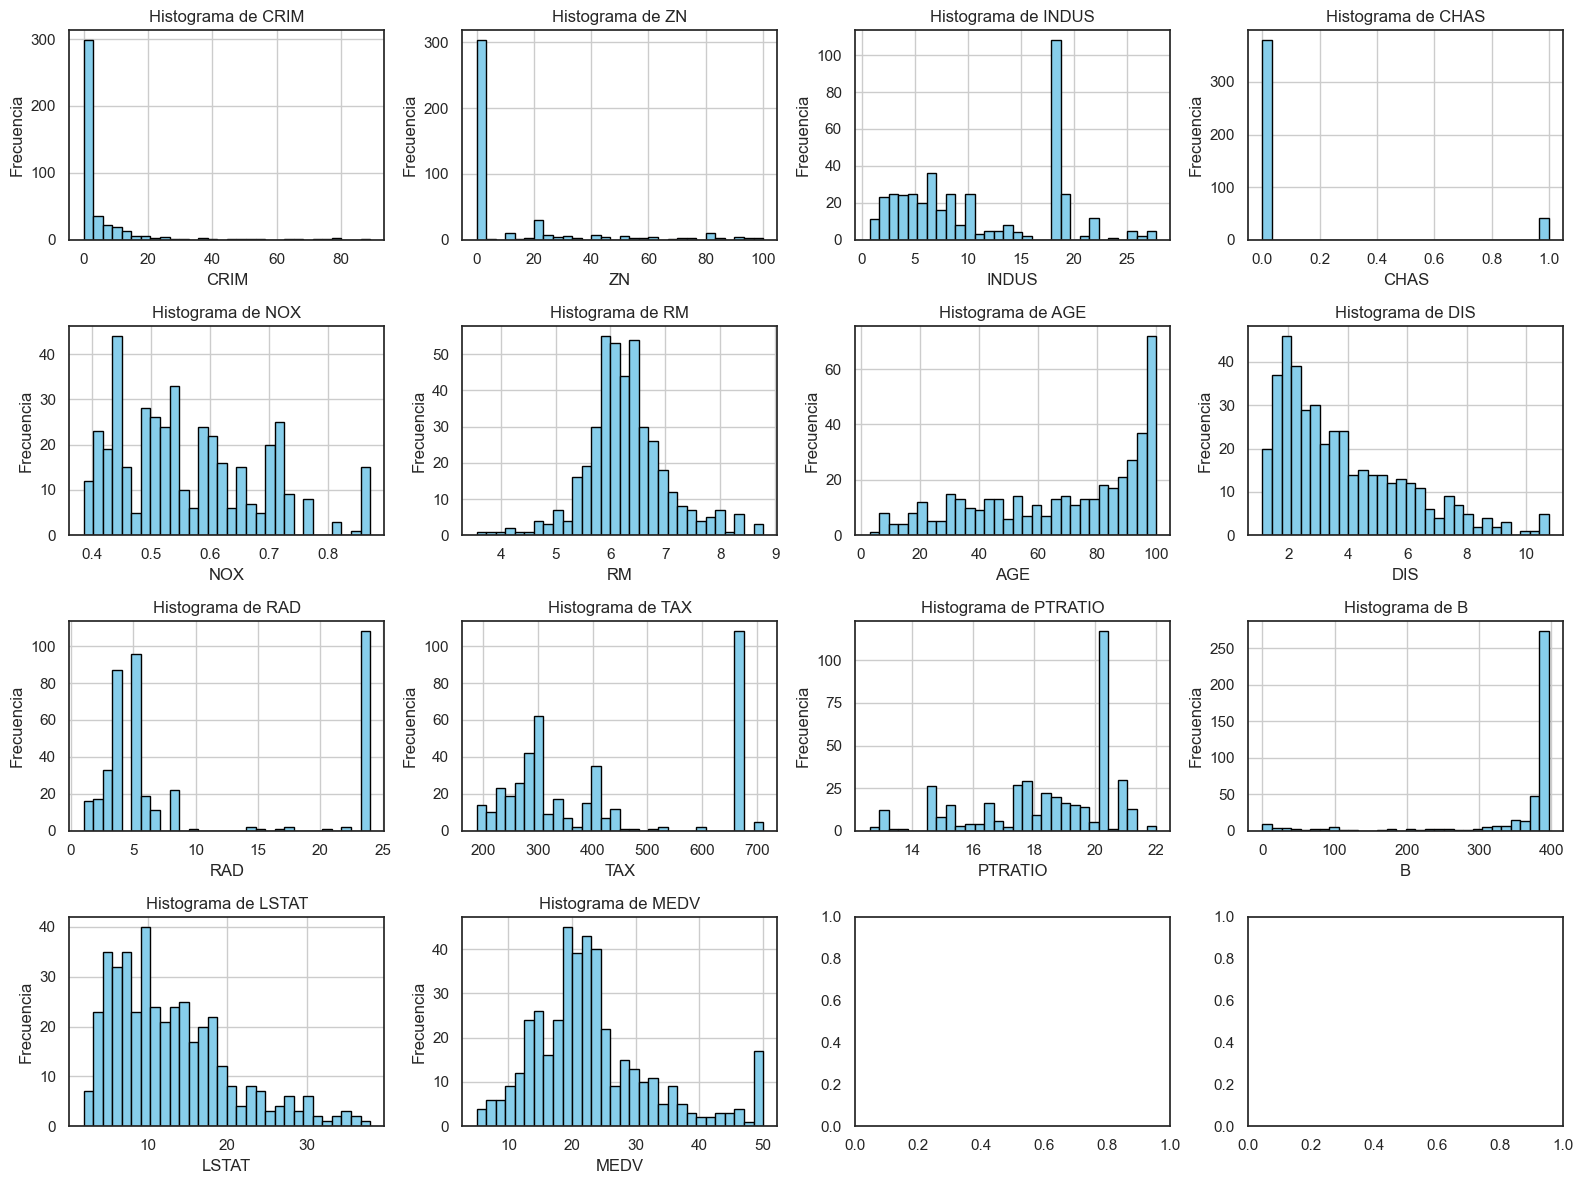

In [75]:
import matplotlib.pyplot as plt

# Lista de columnas para analizar
para_histograma = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

# Determinar el número de filas y columnas para la grilla de subplots
n_cols = 4
n_rows = (len(para_histograma) + n_cols - 1) // n_cols  # Redondea hacia arriba

# Crear figura y subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.ravel()  # Aplanar la matriz de ejes para iterar más fácilmente

# Crear los histogramas
for i, col in enumerate(para_histograma):
    axes[i].hist(train[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)

# Ajustar el layout para que los gráficos no se superpongan
plt.tight_layout()
plt.show()


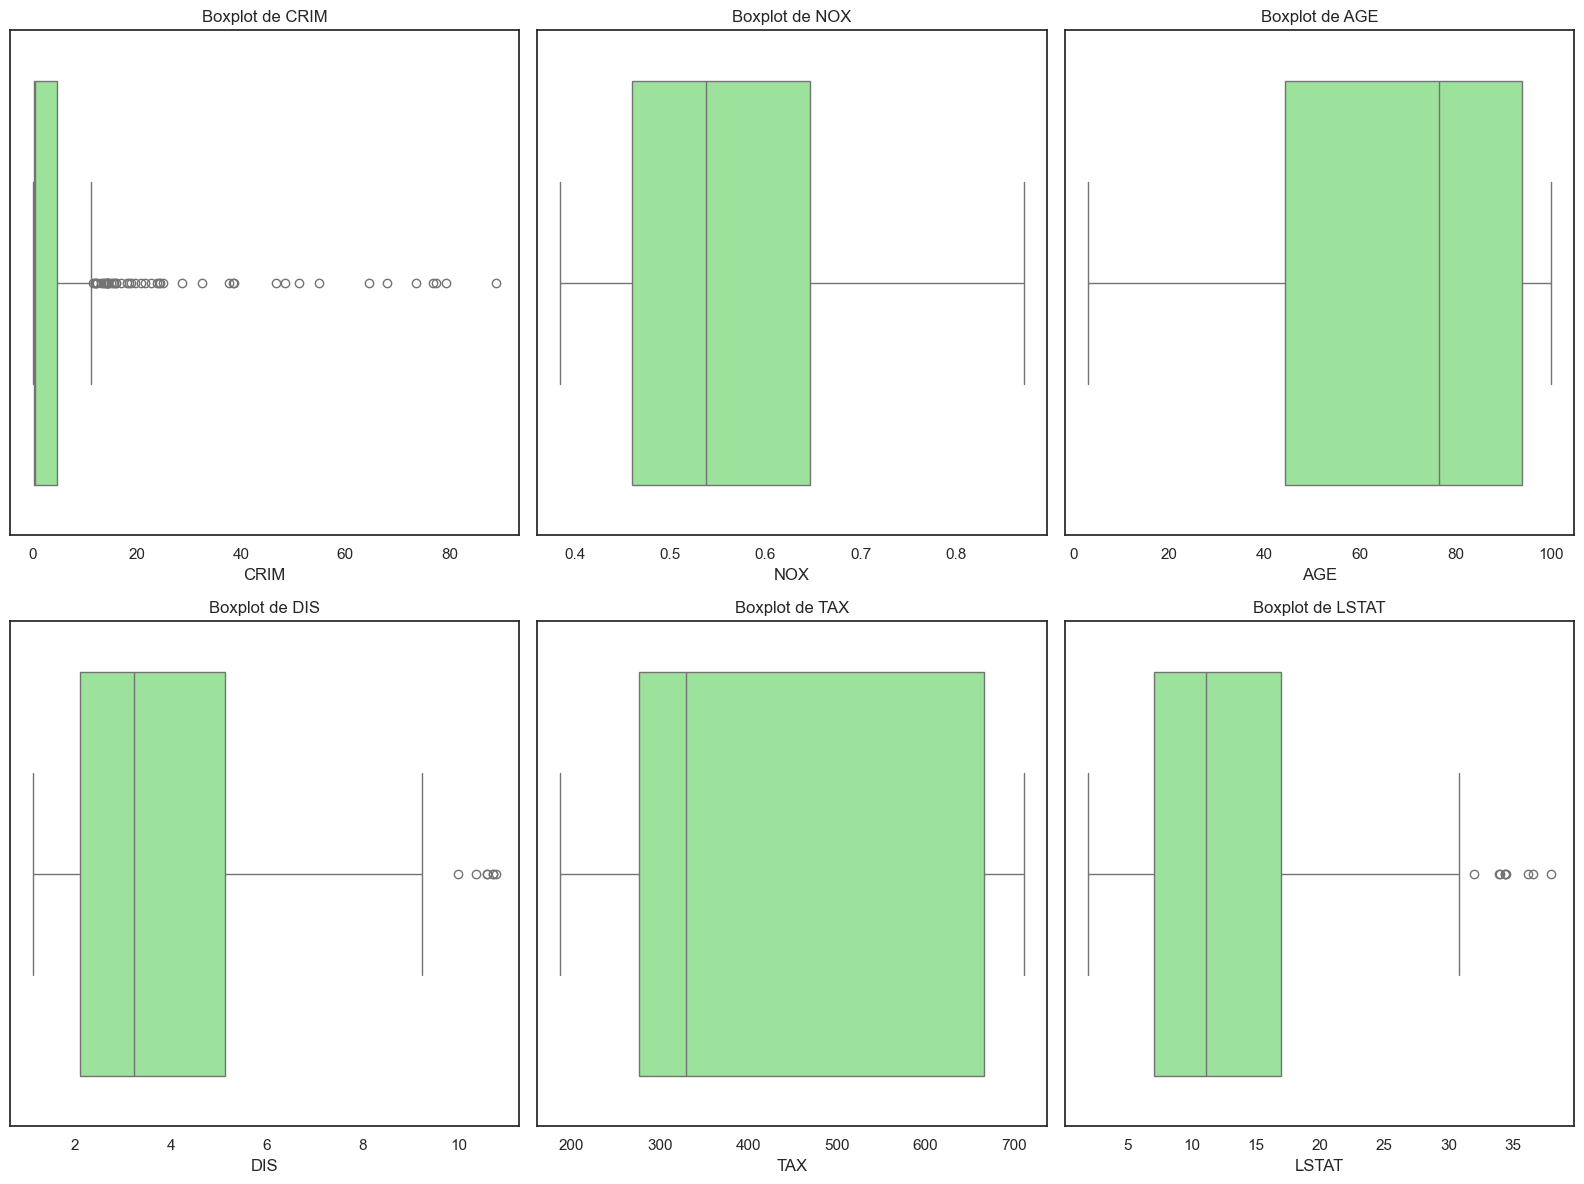

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de columnas para analizar
para_boxplot = ["CRIM", "NOX", "AGE", "DIS", "TAX", "LSTAT"]

# Determinar el número de filas y columnas para la grilla de subplots
n_cols = 3
n_rows = (len(para_boxplot) + n_cols - 1) // n_cols  # Redondea hacia arriba

# Crear figura y subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.ravel()  # Aplanar la matriz de ejes para iterar más fácilmente

# Crear los boxplots
for i, col in enumerate(para_boxplot):
    sns.boxplot(x=train[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot de {col}')

# Eliminar ejes vacíos si hay menos gráficos que espacios en la grilla
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para que los gráficos no se superpongan
plt.tight_layout()
plt.show()


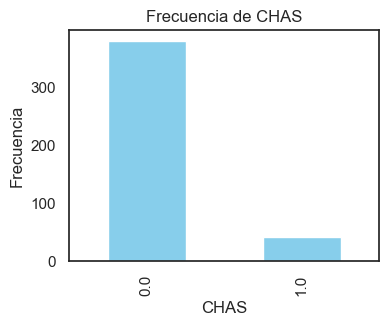

In [77]:
#Chas elegimos mostrarlo en cantidad de frecuencia, para ver cuantas de las Casas tasadas tienen vista al Lago

plt.figure(figsize=(4, 3))
train['CHAS'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frecuencia de CHAS')
plt.xlabel('CHAS')
plt.ylabel('Frecuencia')
plt.show()


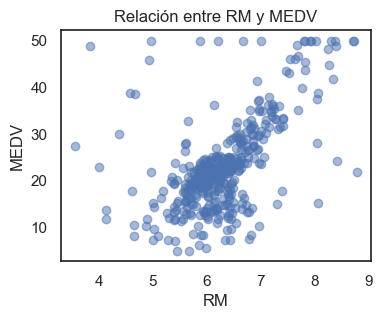

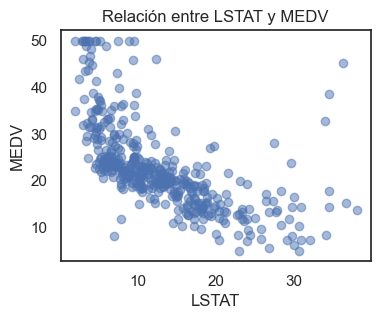

In [78]:
#Utilizamos el ScatterPlot para comparar la relación entre el precio de la vivienda, contra las Variables que en el HeadMap tienen mayor relacion con muestro MEDV (Precio de vivienda)

for i, col in enumerate(['RM', 'LSTAT']):
    plt.figure(figsize=(4, 3))
    plt.scatter(train[col], train['MEDV'], alpha=0.5)
    plt.title(f'Relación entre {col} y MEDV')
    plt.xlabel(col)
    plt.ylabel('MEDV')
    plt.show()


# Manejo de datos faltantes

## Completado de datos


**Datos numéricos:** Usaremos la media para rellenar los datos faltantes, ya que es una medida de tendencia central que representa el valor promedio de los datos. Sin embargo, es importante tener en cuenta que la media puede verse afectada por valores extremos o atípicos (outliers), lo que podría sesgar los resultados. A pesar de esto, hemos decidido usarla en este caso, ya que consideramos que no hay una presencia significativa de outliers que distorsione gravemente los resultados.

**Datos categóricos:** Usaremos la moda para rellenar los datos faltantes, ya que las variables categóricas no son numéricas, y por lo tanto, medidas como la media y la mediana no tienen sentido en este contexto. Al rellenar los datos faltantes con la moda, estamos asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Aunque esto puede no ser siempre exacto, es una suposición razonable en ausencia de información adicional.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [79]:
# Manejo de datos faltantes
# Calcular la media en el conjunto de entrenamiento

#Total Cols ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"

mean_cols = ["ZN", "INDUS", "RM", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
mode_cols = ["CHAS", "ZN", "CRIM"]
median_cols = ["NOX", "AGE"]

#Si es simetrico completar con el promedio
#Si son variables no simetricas, completar con la Mediana
#Las BIMODALES es conveniente completarlas con K-NN
# # Eliminar filas donde todos los valores son nulos
train.dropna(how='all', inplace=True)

# Eliminar filas con valores nulos en la columna 'MEDV'
train = train.dropna(subset=['MEDV'])

# Rellenar nulos en columnas con media
train.loc[:, mean_cols] = train[mean_cols].fillna(train[mean_cols].mean())

# Rellenar nulos en columnas con mediana
train.loc[:, median_cols] = train[median_cols].fillna(train[median_cols].median())
for col in mode_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)


C:\Users\brisa\AppData\Local\Temp\ipykernel_9764\3387255710.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(how='all', inplace=True)
C:\Users\brisa\AppData\Local\Temp\ipykernel_9764\3387255710.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)


Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [80]:
train.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [81]:
# Manejo de datos faltantes
# Calcular la media 
#numeric_cols = X_train.select_dtypes(include=np.number).columns

mean_cols = ["ZN", "INDUS", "RM", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
mode_cols = ["CHAS", "ZN", "CRIM"]
median_cols = ["NOX", "AGE"]

# Usar las estadísticas calculadas en el conjunto de entrenamiento para imputar en el conjunto de prueba
test[mean_cols] = test[mean_cols].fillna(train[mean_cols].mean())
test[median_cols] = test[median_cols].fillna(train[median_cols].median())
for col in mode_cols:
    test[col].fillna(train[col].mode()[0], inplace=True)


C:\Users\brisa\AppData\Local\Temp\ipykernel_9764\1155095386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[mean_cols] = test[mean_cols].fillna(train[mean_cols].mean())
C:\Users\brisa\AppData\Local\Temp\ipykernel_9764\1155095386.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[median_cols] = test[median_cols].fillna(train[median_cols].median())
C:\Users\brisa\AppData\Local\Temp\ipykernel_9764\1155095386.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series t

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [82]:
test.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Matriz de correlación

Como nuestra unica variable Dummy (CHAS) ya viene expresada en ceros y unos, no debemos modificarla.

La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

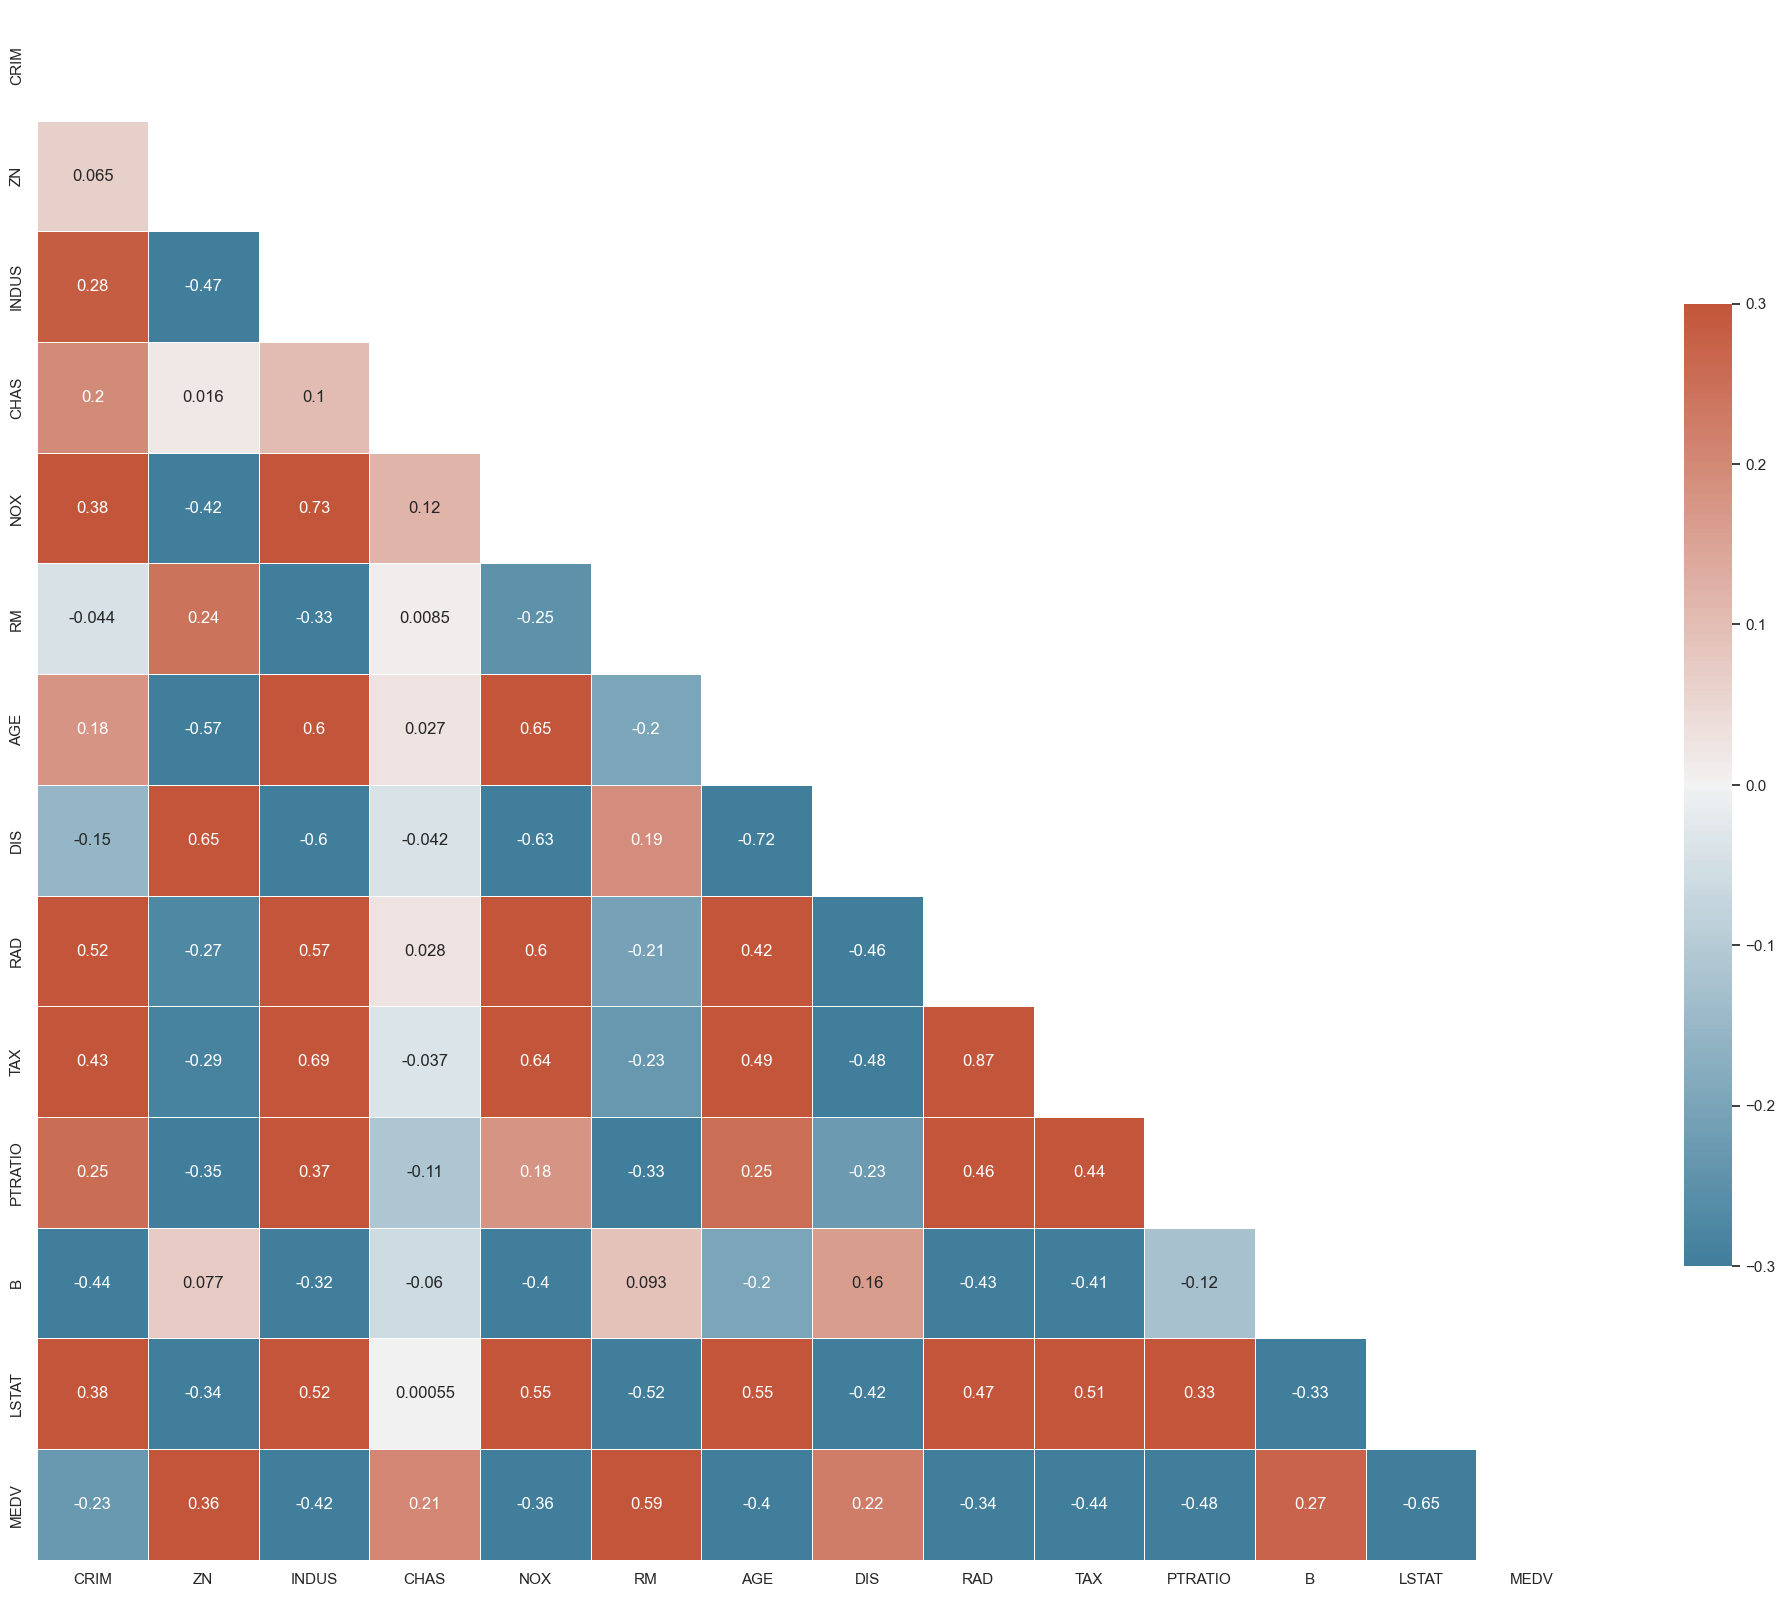

In [83]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


### **Relación de las variables con el precio de la vivienda (MEDV)**

- LSTAT (Porcentaje de población de estatus bajo): Correlación negativa fuerte (-0.65) con el precio de la vivienda (MEDV). Esto indica que, a medida que aumenta el porcentaje de personas de estatus bajo en una zona, el valor de las viviendas tiende a disminuir.
- RM (Número medio de habitaciones por vivienda): Correlación positiva significativa (0.55). A mayor número de habitaciones promedio, mayor es el precio de las viviendas, lo que tiene sentido ya que las casas más grandes suelen ser más caras.
- PTRATIO (Relación estudiante-profesor por zona): Correlación negativa moderada (-0.44). Un mayor PTRATIO (más estudiantes por maestro) parece estar asociado con precios de vivienda más bajos, lo que puede reflejar la calidad educativa de la zona.
- NOX (Concentración de óxidos nítricos): Correlación negativa moderada (-0.31). A mayor contaminación por NOX, los precios de las viviendas tienden a ser menores, lo cual es esperado en áreas con peor calidad ambiental.

### **Correlación entre las variables**
- TAX y RAD: Alta correlación positiva (0.87). Esto podría indicar que los distritos con mayor acceso a autopistas (RAD) tienden a tener impuestos más altos, lo que puede reflejar el desarrollo urbano en esas áreas.
- NOX y INDUS: Alta correlación positiva (0.73). Esto tiene sentido porque las áreas más industrializadas (INDUS) suelen tener niveles más altos de contaminación (NOX).
- DIS y INDUS: Correlación negativa significativa (-0.68). La distancia a centros de empleo (DIS) está negativamente correlacionada con la proporción de terrenos industriales, lo que sugiere que las zonas más alejadas de los centros urbanos tienen menos áreas industriales.

### **Otras observaciones importantes**

- CRIM (Índice de criminalidad per cápita) no muestra una correlación particularmente fuerte con el precio de la vivienda (-0.31), aunque hay una leve tendencia a que, a mayor criminalidad, los precios tiendan a bajar.
- AGE (Proporción de unidades construidas antes de 1940): Tiene una relación negativa moderada con el precio de la vivienda (-0.32), lo que puede reflejar que las casas más antiguas suelen tener un valor menor.

# División del conjunto de datos de entrenamiento y estandarizacion


In [84]:
# Definir características (X) y variable objetivo (y)
X_train = train[['ZN', 'INDUS',"CRIM", "RAD", "CHAS", "DIS", "B", 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT']]
Y_train = train['MEDV']

#Intentamos quitar variables no tan relacionadas, pero las metricas del modelo se ven perjudicadas

X_test = test[['ZN', 'INDUS', "CRIM", "RAD", "CHAS", "DIS", "B", 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT']]
Y_test = test['MEDV']

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Usa el mismo escalador



**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# Regresión Lineal

La regresión lineal modela una relación lineal entre la variable dependiente y las variables independientes.

In [85]:
# Crea una instancia del modelo de regresión lineal
model_rl = LinearRegression()
model_rl.fit(X_train_scaled, Y_train) 

LinearRegression()

In [86]:
y_train_pred = model_rl.predict(X_train_scaled)
y_pred = model_rl.predict(X_test_scaled)

#### Coeficiente e Intercepción

In [87]:
coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print(f"\nIntercept:", intercept)

Coefficients: [ 0.90189699  0.32877037  0.19240251  1.92656617  1.90348911 -2.22147544
  0.72041471 -0.38693825  2.85839117 -1.68635298 -2.23949375 -1.93028206
 -3.18302871]

Intercept: 23.079336589240434


#### Métricas del set de entrenamiento

In [88]:
# MSE: Error Cuadratico Medio
mse_train = mean_squared_error(Y_train, y_train_pred)

# R^2
r2_train = r2_score(Y_train, y_train_pred)    

# MAE: Error Absoluto Medio
mae_train = mean_absolute_error(Y_train, y_train_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))

print(f"\nR²: {r2_train}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train}\n")
print(f"MAE(Error Absoluto Medio): {mae_train}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train}\n")


R²: 0.5998947587355183

MSE(Error Cuadratico Medio): 36.64358039027652

MAE(Error Absoluto Medio): 4.023072699633426

RMSE(Raíz del Error Cuadrático Medio): 6.053394121505431



#### Métricas del set de testeo

In [89]:
# MSE: Error Cuadratico Medio
mse = mean_squared_error(Y_test, y_pred)

# R^2
r2 = r2_score(Y_test, y_pred)  #Da super mal

# MAE: Error Absoluto Medio
mae = mean_absolute_error(Y_test, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"\nR²: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")


R²: 0.7298380281761165

MSE(Error Cuadratico Medio): 21.895397100181956

MAE(Error Absoluto Medio): 3.454068816112924

RMSE(Raíz del Error Cuadrático Medio): 4.679251767129223



# Gradiente descendiente

In [90]:
#Para el GD, tomamos la función del Colab de Clases

def gradient_descent(X_train_scaled, Y_train, lr=0.01, epochs=100):
    """
    X_train_scaled: nxm (matriz de características escaladas de entrenamiento)
    Y_train: nx1 (vector de salida de entrenamiento)
    lr: tasa de aprendizaje
    epochs: número de iteraciones
    """
    # Copias de las variables para evitar modificaciones en las originales
    X_train = X_train_scaled.copy()
    Y_train = Y_train.copy()  # Cambié Y_test a Y_train

    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características (columnas)

    # Agregar columna de unos a las matrices X (bias/intercepto)
    X_train = np.hstack((np.ones((n, 1)), X_train))

    # Convertir Y_train a arrays de numpy y asegurarse de que sean de la forma correcta
    Y_train = Y_train.values.reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época

    for epoch in range(epochs):
        # Predicción y error en el conjunto de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = Y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Gradiente y actualización de los pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2 / n * grad_sum
        gradient = grad_mul.reshape(-1, 1)

        W = W - (lr * gradient)

    # Graficar los errores
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento vs iteraciones (Gradiente Descendente)')
    plt.show()

    return W


In [91]:
# Por ejemplo, usar el 80% de los datos para entrenamiento y el 20% para validación

train_size = int(0.8 * X_train_scaled.shape[0])
X_train_split = X_train_scaled[:train_size]
Y_train_split = Y_train[:train_size]


#### Métricas del set de testeo

In [92]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calcular_metricas(X, y, W_opt):
    """
    Calcula MSE, RMSE, MAE y R² para los datos (X, y) y los pesos W_opt.
    """
    # Asegurar que X tiene la columna de unos (bias)
    n = X.shape[0]
    X = np.hstack((np.ones((n, 1)), X))  # Agregar columna de unos

    # Predicciones
    y_pred = np.dot(X, W_opt)

    # Asegurar que y es un array de numpy y no una serie de pandas
    y = y.to_numpy() if hasattr(y, 'to_numpy') else y
    y_pred = y_pred.ravel()

    # Calcular métricas
    mse = mean_squared_error(y, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return mse, rmse, mae, r2


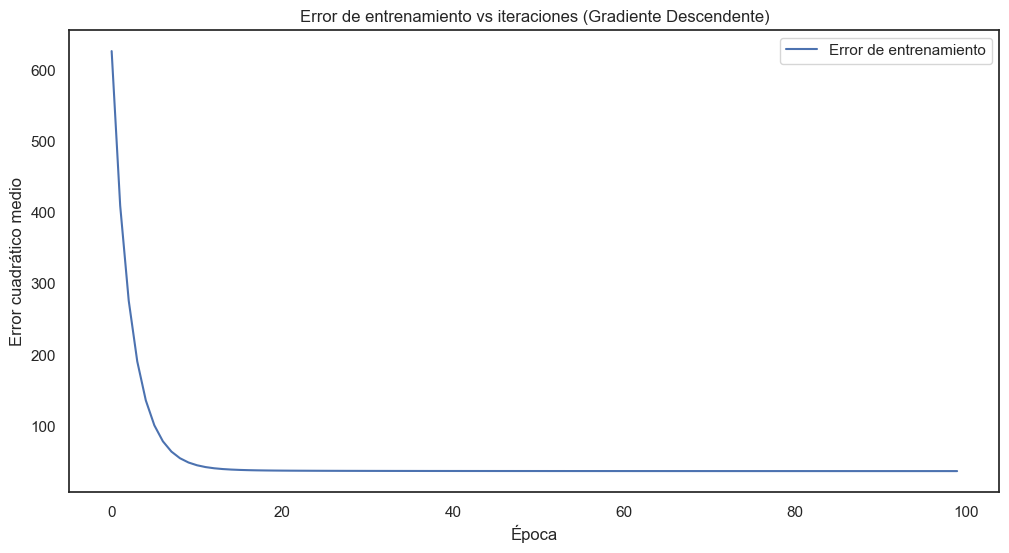

In [93]:
W_opt = gradient_descent(X_train_scaled, Y_train, lr=0.1, epochs=100)


In [94]:
# Calcular métricas
train_mse, train_rmse, train_mae, train_r2 = calcular_metricas(X_train_split, Y_train_split, W_opt)

print(f"Métricas de Entrenamiento - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")


Métricas de Entrenamiento - MSE: 39.7187, RMSE: 6.3023, MAE: 4.1441, R²: 0.5943


Como podemos ver en la grafica comparativa Loss vs Epochs, entre la Epoca 10/15, vemos que el error llega a su punto casi minimo.
Ademas, en cuanto a las metricas de Entrenamiento , obtenemos resultados similares a la Regresión Lineal

# Lasso, Ridge y Elastic Net

## Lasso

Penaliza la suma de los valores absolutos de los coeficientes, lo que puede llevar a algunos coeficientes a ser exactamente cero. Esto es útil para la selección de variables, ya que permite identificar las características más importantes.

In [95]:
lasso = Lasso(alpha=0.1) # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(X_train_scaled, Y_train)

Lasso(alpha=0.1)

In [96]:
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("\nCoeficientes del modelo Lasso de train:", lasso.score(X_train_scaled, Y_train))
print("Coeficientes del modelo Lasso de test:", lasso.score(X_test_scaled, Y_test))

Coeficientes del modelo Lasso:
[ 0.64451201 -0.          0.07100594  0.8804374   1.91479438 -1.69036604
  0.55239276 -0.03513547  2.83267858 -1.51432963 -1.15906374 -1.79086286
 -3.21176509]

Coeficientes del modelo Lasso de train: 0.5958886414126762
Coeficientes del modelo Lasso de test: 0.713990524662943


In [97]:
#'feature_names' es una lista con los nombres de las características
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)

# Error Cuadrático Medio (MSE)
mse_train_lasso = mean_squared_error(Y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(Y_test, y_pred_test_lasso)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_lasso = sqrt(mse_train_lasso)
rmse_test_lasso = sqrt(mse_test_lasso)

# Error Absoluto Medio (MAE)
mae_train_lasso = mean_absolute_error(Y_train, y_pred_train_lasso)
mae_test_lasso = mean_absolute_error(Y_test, y_pred_test_lasso)

# Coeficiente de determinación (R²)
r2_train_lasso = r2_score(Y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(Y_test, y_pred_test_lasso)

# Crear un DataFrame para las métricas del modelo
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Train': [mse_train_lasso, rmse_train_lasso, mae_train_lasso, r2_train_lasso],
    'Test': [mse_test_lasso, rmse_test_lasso, mae_test_lasso, r2_test_lasso]
})

# Imprimir el DataFrame de métricas
print("Métricas del modelo Lasso:")
print(metrics_df)

# Crear un DataFrame para los coeficientes del modelo
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_
})

# Filtrar los coeficientes no nulos
coefficients_df = coefficients_df[abs(coefficients_df['Coefficient']) > 1e-5]

# Agregar el término independiente al DataFrame
intercept_df = pd.DataFrame({
    'Feature': ['Intercept'],
    'Coefficient': [lasso.intercept_]
})

# Concatenar el término independiente con los coeficientes
coefficients_df = pd.concat([coefficients_df, intercept_df], ignore_index=True)

# Imprimir el DataFrame de coeficientes
print("\nCoeficientes del modelo Lasso:")
print(coefficients_df)

# Número de coeficientes no nulos
non_zero_coef = len(coefficients_df) - 1  # Restar 1 por el intercepto
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Métricas del modelo Lasso:
  Metric      Train       Test
0    MSE  37.010480  23.179765
1   RMSE   6.083624   4.814537
2    MAE   4.041417   3.529080
3     R²   0.595889   0.713991

Coeficientes del modelo Lasso:
      Feature  Coefficient
0        CRIM     0.644512
1       INDUS     0.071006
2        CHAS     0.880437
3         NOX     1.914794
4          RM    -1.690366
5         AGE     0.552393
6         DIS    -0.035135
7         RAD     2.832679
8         TAX    -1.514330
9     PTRATIO    -1.159064
10          B    -1.790863
11      LSTAT    -3.211765
12  Intercept    23.079337

Número de características seleccionadas: 12


Lo que podemos identificar gracias al modelo de Lasso, es que variables como LSTAT, RM, RAD, TAX, PRATIO, B, NOX, son variables que afectan fuertemente en nuestro modelo, tanto positiva como negativamente.
Y por otro lado, variables como INDUS,CHAS, por mencionar algunas, no son variables extremadamente importantes en el resultado final de nuestro modelo para identificar el Valor Estimado de la Propiedad. 

## Ridge

In [98]:
ridge = Ridge(alpha=0.1) # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(X_train_scaled, Y_train)

Ridge(alpha=0.1)

In [99]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(X_train_scaled, Y_train))
print("Coeficientes del modelo Ridge de test:", ridge.score(X_test_scaled, Y_test))

Coeficientes del modelo Ridge:
[ 0.90081569  0.3263166   0.1924303   1.92151451  1.90363222 -2.21946593
  0.72004322 -0.38607332  2.8579962  -1.68549694 -2.23358329 -1.92990692
 -3.18264764]

Coeficientes del modelo Ridge de train: 0.5998946720601683
Coeficientes del modelo Ridge de test: 0.7298123076134404


In [100]:
# Primero, hacemos las predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_ridge = ridge.predict(X_train_scaled)
y_pred_test_ridge = ridge.predict(X_test_scaled)

In [101]:
# Error Cuadrático Medio (MSE)
mse_train_ridge = mean_squared_error(Y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(Y_test, y_pred_test_ridge)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_ridge = sqrt(mse_train_ridge)
rmse_test_ridge = sqrt(mse_test_ridge)

# Error Absoluto Medio (MAE)
mae_train_ridge = mean_absolute_error(Y_train, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(Y_test, y_pred_test_ridge)

# Coeficiente de determinación (R²)
r2_train_ridge = r2_score(Y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(Y_test, y_pred_test_ridge)

In [102]:
# Imprimir resultados
print("Métricas para el modelo Ridge:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_ridge:.4f}")
print(f"RMSE: {rmse_train_ridge:.4f}")
print(f"MAE: {mae_train_ridge:.4f}")
print(f"R²: {r2_train_ridge:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_ridge:.4f}")
print(f"RMSE: {rmse_test_ridge:.4f}")
print(f"MAE: {mae_test_ridge:.4f}")
print(f"R²: {r2_test_ridge:.4f}")

Métricas para el modelo Ridge:

Conjunto de entrenamiento:
MSE: 36.6436
RMSE: 6.0534
MAE: 4.0229
R²: 0.5999

Conjunto de prueba:
MSE: 21.8975
RMSE: 4.6795
MAE: 3.4539
R²: 0.7298


In [103]:
# Coeficientes del modelo Ridge
print("\nCoeficientes del modelo Ridge:")

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge.coef_
})

# Filtrar coeficientes no nulos
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-5]

# Imprimir los coeficientes
print(coef_df)

# Intercept (término independiente)
print(f"\nIntercept: {ridge.intercept_:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(ridge.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Coeficientes del modelo Ridge:
    Feature  Coefficient
0      CRIM     0.900816
1        ZN     0.326317
2     INDUS     0.192430
3      CHAS     1.921515
4       NOX     1.903632
5        RM    -2.219466
6       AGE     0.720043
7       DIS    -0.386073
8       RAD     2.857996
9       TAX    -1.685497
10  PTRATIO    -2.233583
11        B    -1.929907
12    LSTAT    -3.182648

Intercept: 23.0793

Número de características seleccionadas: 13


Segun Ridge, varía un poco de nuestros coeficientes mostrados previamente con Lasso.
Para Ridge, las variables menos significativas pasan a ser INDUS (Tambien mencionada en Lasso) y AGE. Pero como vemos, la variable CHAS, correspondiente a la vista al Lago, para Ridge es altamente significativa en cuanto a la afectación en nuestro modelo predictivo, lo cual el modelo Lasso la identificaba como una Variable poco importante.


## Elastic Net

In [104]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(X_train_scaled, Y_train)

ElasticNet(alpha=0.1)

In [105]:
print("Coeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("\nCoeficientes del modelo ElasticNet de train:", elasticnet.score(X_train_scaled, Y_train))
print("Coeficientes del modelo ElasticNet de test:", elasticnet.score(X_test_scaled, Y_test))

Coeficientes del modelo ElasticNet:
[ 0.66803198 -0.00973534  0.11419494  0.91524269  1.87319089 -1.64803274
  0.58983933 -0.16541476  2.77419376 -1.4358459  -1.17563023 -1.80430076
 -3.08438214]

Coeficientes del modelo ElasticNet de train: 0.5954506143245657
Coeficientes del modelo ElasticNet de test: 0.7169795583132763


In [106]:
# Primero, hacemos predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = elasticnet.predict(X_train_scaled)
y_pred_test = elasticnet.predict(X_test_scaled)

# Error Cuadrático Medio (MSE)
mse_train = mean_squared_error(Y_train, y_pred_train)
mse_test = mean_squared_error(Y_test, y_pred_test)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)

# Error Absoluto Medio (MAE)
mae_train = mean_absolute_error(Y_train, y_pred_train)  # Agregué y_pred_train aquí
mae_test = mean_absolute_error(Y_test, y_pred_test)

# Coeficiente de determinación (R²)
r2_train = r2_score(Y_train, y_pred_train)
r2_test = r2_score(Y_test, y_pred_test)

# Imprimir resultados
print("Métricas para el modelo ElasticNet:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R²: {r2_test:.4f}")


Métricas para el modelo ElasticNet:

Conjunto de entrenamiento:
MSE: 37.0506
RMSE: 6.0869
MAE: 4.0397
R²: 0.5955

Conjunto de prueba:
MSE: 22.9375
RMSE: 4.7893
MAE: 3.5206
R²: 0.7170


In [107]:
# Coeficientes del modelo elasticnet
print("\nCoeficientes del modelo elasticnet:")

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elasticnet.coef_
})

# Filtrar coeficientes no nulos
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-5]

# Imprimir los coeficientes
print(coef_df)

# Intercept (término independiente)
print(f"\nIntercept: {elasticnet.intercept_:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(elasticnet.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Coeficientes del modelo elasticnet:
    Feature  Coefficient
0      CRIM     0.668032
1        ZN    -0.009735
2     INDUS     0.114195
3      CHAS     0.915243
4       NOX     1.873191
5        RM    -1.648033
6       AGE     0.589839
7       DIS    -0.165415
8       RAD     2.774194
9       TAX    -1.435846
10  PTRATIO    -1.175630
11        B    -1.804301
12    LSTAT    -3.084382

Intercept: 23.0793

Número de características seleccionadas: 13


ElasticNet, es nuestro equilibrio entre Lasso y Ridge, como vemos siguiendo con la Variable ejemplo que estabamos tomando previamente, llamada CHAS, en nuestro modelo Lasso, la clasificaba con un bajo coeficiente. En nuestro modelo Ridge, la clasificaba como una variable de alta importancia.
Como vemos en ElasticNet, la variable CHAS, es considerada un intermedio de Lasso y Ridge, considerandola una variable intermedia, es decir, no es la que mas afecta a nuestro modelo predictivo, pero tampoco es considerada una variable a descartar.

Ademas, matiene la linea que veníamos observando previamente, en la que INDUS y AGE pueden ser variables a quitar de nuestro modelo para mejorar la predicción del mismo y eficientizar el rendimiento.


## Gráfico comparativo

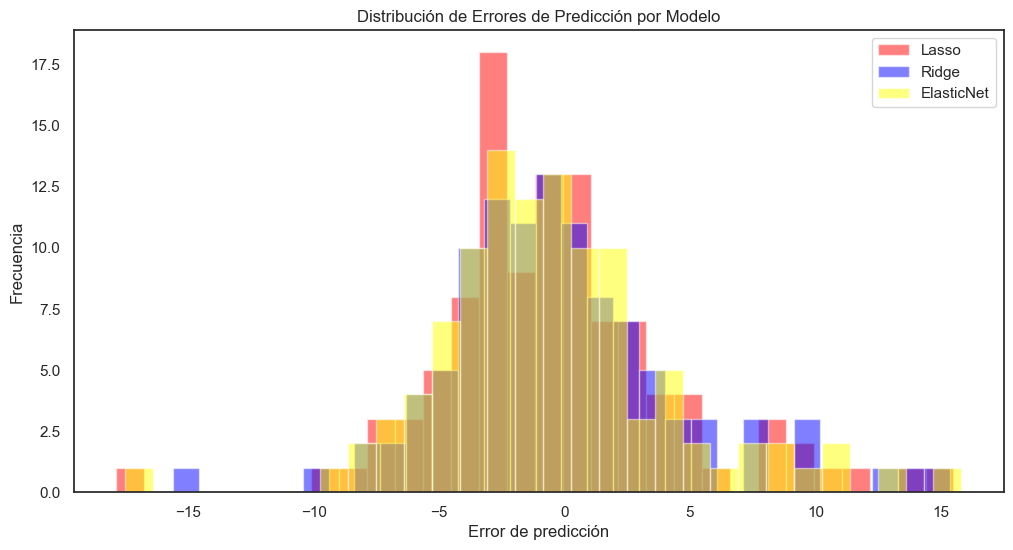

In [108]:
plt.figure(figsize=(12, 6))

plt.hist(Y_test - lasso.predict(X_test_scaled), bins=30, alpha=0.5, label='Lasso', color='red')
plt.hist(Y_test - ridge.predict(X_test_scaled), bins=30, alpha=0.5, label='Ridge', color='blue')
plt.hist(Y_test - elasticnet.predict(X_test_scaled), bins=30, alpha=0.5, label='ElasticNet', color='yellow')

plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción por Modelo')
plt.legend()
plt.show()




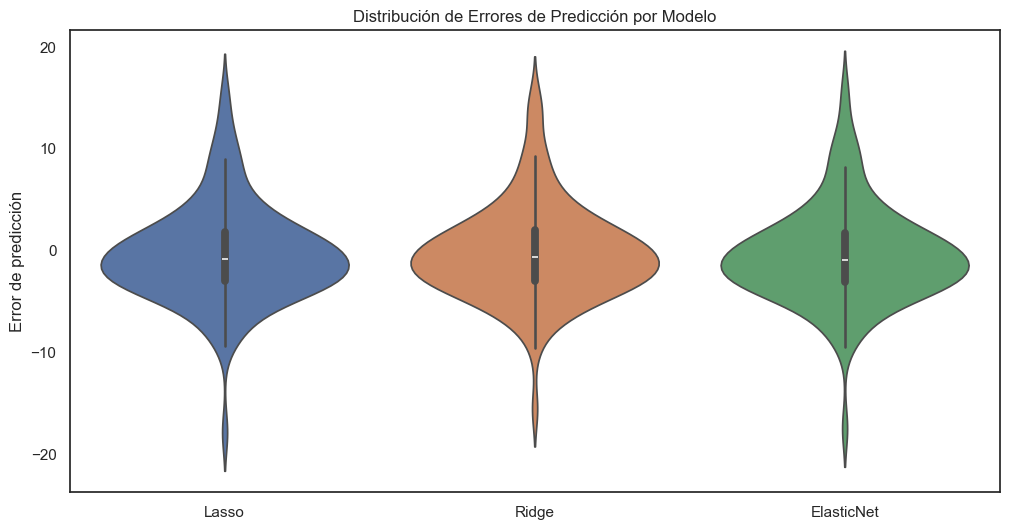

In [109]:
errors_lasso = Y_test - lasso.predict(X_test_scaled)
errors_ridge = Y_test - ridge.predict(X_test_scaled)
errors_elasticnet = Y_test - elasticnet.predict(X_test_scaled)

#Creo el DF con los errores para luego compararlos
df_errors = pd.DataFrame({
    'Lasso': errors_lasso,
    'Ridge': errors_ridge,
    'ElasticNet': errors_elasticnet
})

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_errors)
plt.title('Distribución de Errores de Predicción por Modelo')
plt.ylabel('Error de predicción')
plt.show()

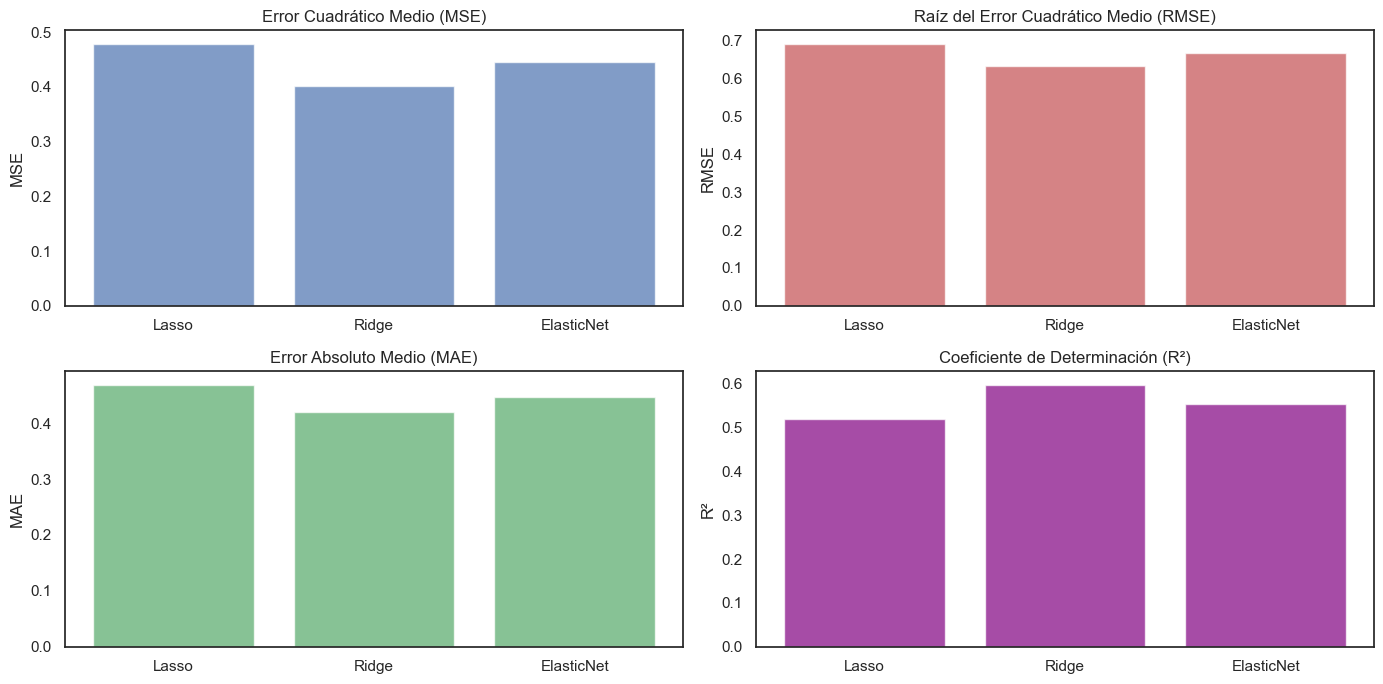

In [110]:
# Datos de métricas en listas
model_names = ['Lasso', 'Ridge', 'ElasticNet']
mse_values = [0.479362, 0.4014, 0.4457]
rmse_values = [ 0.692360, 0.6335, 0.6676]
mae_values = [0.469114, 0.4195, 0.4468]
r2_values = [0.520638, 0.5986, 0.5543]

x = range(len(model_names))

plt.figure(figsize=(14, 7))

# Gráfico de MSE
plt.subplot(2, 2, 1)
plt.bar(x, mse_values, color='b', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MSE')
plt.title('Error Cuadrático Medio (MSE)')

# Gráfico de RMSE
plt.subplot(2, 2, 2)
plt.bar(x, rmse_values, color='r', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('RMSE')
plt.title('Raíz del Error Cuadrático Medio (RMSE)')

# Gráfico de MAE
plt.subplot(2, 2, 3)
plt.bar(x, mae_values, color='g', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MAE')
plt.title('Error Absoluto Medio (MAE)')

# Gráfico de R²
plt.subplot(2, 2, 4)
plt.bar(x, r2_values, color='purple', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('R²')
plt.title('Coeficiente de Determinación (R²)')

plt.tight_layout()
plt.show()


### Conclusiones generales:
- Ridge parece ser el modelo que mejor ajusta los datos en todas las métricas presentadas, con los menores valores de error y el mayor R².
- Lasso tiene un desempeño ligeramente peor en comparación con ElasticNet y Ridge, especialmente en el MSE y R².
- ElasticNet ofrece un desempeño intermedio, mostrando valores de error y ajuste cercanos a los de Ridge, pero sin superarlo en ninguna métrica.

Es esencial calcular las métricas en los conjuntos de **entrenamiento** y **prueba** para evaluar tanto cómo el modelo ha aprendido de los datos como su capacidad de generalizar a nuevos casos. Esto permite detectar **overfitting** o **underfitting**. Métricas como R², MSE, RMSE y MAE nos dan una visión clara del rendimiento y ajuste del modelo.

Ridge parece ofrecer el mejor fitting, con un balance adecuado entre precisión y generalización, mientras que ElasticNet también es una opción viable, pero Lasso muestra un ajuste más débil en comparación

# Optimizamos la selección de hiperparámetros.

### Variar los hiperparámetros de gradiente descendiente

In [111]:

# Crear el modelo de regresión
sgd_reg = SGDRegressor(random_state=42)

# Definir los parámetros para Grid Search
sgd_param_grid = {
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'alpha': np.logspace(-4, -1, num=10),  # Genera 10 valores de alpha entre 0.0001 y 0.1
    'max_iter': [1000, 2000, 3000],
    'penalty': ['l2', 'l1', 'elasticnet']
}

# Realizar la búsqueda de hiperparámetros con Grid Search
sgd_grid_search = GridSearchCV(estimator=sgd_reg, param_grid=sgd_param_grid, cv=5, n_jobs=-1)
start = time.time()
sgd_grid_search.fit(X_train_scaled, Y_train)
end = time.time()
sgd_grid_search_time = end - start

# Evaluar el modelo
y_pred_sgd = sgd_grid_search.predict(X_test_scaled)
sgd_mse = mean_squared_error(Y_test, y_pred_sgd)
sgd_r2 = r2_score(Y_test, y_pred_sgd)

# Resultados
print("Mejores parámetros encontrados con SGD:", sgd_grid_search.best_params_)
print("Tiempo de entrenamiento con SGD (s):", sgd_grid_search_time)
print("MSE:", sgd_mse)
print("R2 Score:", sgd_r2)


Mejores parámetros encontrados con SGD: {'alpha': 0.021544346900318822, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'elasticnet'}
Tiempo de entrenamiento con SGD (s): 10.890538692474365
MSE: 21.644903187578322
R2 Score: 0.7329288115516924


### Variar los hiperparámetros de Lasso y Ridge


In [112]:

# Crear el modelo de Lasso
lasso = Lasso()

# Definir los parámetros para Grid Search en Lasso
lasso_param_grid = {
    'alpha': np.logspace(-3, 1, num=5)  # Genera 5 valores de alpha entre 0.001 y 10
}

# Realizar la búsqueda de hiperparámetros con Grid Search en Lasso
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, cv=5, n_jobs=-1)
start = time.time()
lasso_grid_search.fit(X_train_scaled, Y_train)
end = time.time()
lasso_grid_search_time = end - start

# Evaluar el modelo de Lasso
y_pred_lasso = lasso_grid_search.predict(X_test_scaled)
lasso_mse = mean_squared_error(Y_test, y_pred_lasso)
lasso_r2 = r2_score(Y_test, y_pred_lasso)

print("Mejores parámetros encontrados con Lasso:", lasso_grid_search.best_params_)
print("Tiempo de entrenamiento con Lasso (s):", lasso_grid_search_time)
print("MSE:", lasso_mse)
print("R2 Score:", lasso_r2)
print("------------------------------------")
print("------------------------------------")

# Crear el modelo de Ridge
ridge = Ridge()

# Definir los parámetros para Grid Search en Ridge
ridge_param_grid = {
    'alpha': np.logspace(-3, 1, num=5)  # Genera 5 valores de alpha entre 0.001 y 10
}

# Realizar la búsqueda de hiperparámetros con Grid Search en Ridge
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=5, n_jobs=-1)
start = time.time()
ridge_grid_search.fit(X_train_scaled, Y_train)
end = time.time()
ridge_grid_search_time = end - start

# Evaluar el modelo de Ridge
y_pred_ridge = ridge_grid_search.predict(X_test_scaled)
ridge_mse = mean_squared_error(Y_test, y_pred_ridge)
ridge_r2 = r2_score(Y_test, y_pred_ridge)

print("Mejores parámetros encontrados con Ridge:", ridge_grid_search.best_params_)
print("Tiempo de entrenamiento con Ridge (s):", ridge_grid_search_time)
print("MSE:", ridge_mse)
print("R2 Score:", ridge_r2)


Mejores parámetros encontrados con Lasso: {'alpha': 0.1}
Tiempo de entrenamiento con Lasso (s): 0.07026338577270508
MSE: 23.179765067016532
R2 Score: 0.713990524662943
------------------------------------
------------------------------------
Mejores parámetros encontrados con Ridge: {'alpha': 10.0}
Tiempo de entrenamiento con Ridge (s): 0.06359171867370605
MSE: 22.134606620925275
R2 Score: 0.7268864801631999


**Valores de alpha en Lasso y Ridge**

Para optimizar los modelos de regresión Lasso y Ridge, se seleccionaron los siguientes valores para el parámetro de regularización alpha: **[0.1, 1.0, 10.0].** 
Estos valores fueron elegidos por las siguientes razones:

*Rango de Regularización:*

0.1: Representa una regularización ligera, permitiendo que el modelo ajuste más libremente a los datos de entrenamiento, lo que puede llevar a un sobreajuste.
1.0: Proporciona un equilibrio moderado entre ajuste del modelo y penalización de los coeficientes, buscando una mejor generalización.
10.0: Impone una fuerte regularización, lo que simplifica el modelo al reducir la magnitud de los coeficientes y minimizar el riesgo de sobreajuste.

*Propósito*:

- Explorar el Impacto: Evaluar cómo diferentes niveles de penalización (alpha) afectan el rendimiento del modelo en términos de MSE y R².
- Equilibrio Sesgo-Varianza: Encontrar un valor óptimo de alpha que balancee el sesgo y la varianza para mejorar la generalización del modelo.

**max_iter**
Es el número máximo de iteraciones que el algoritmo de gradiente descendente realizará para ajustar los pesos del modelo.
**1000, 2000, 3000** son valores típicos utilizados para experimentar y encontrar el equilibrio adecuado entre convergencia y tiempo de entrenamiento.

# Comparación de Modelos de Regresión usando MSE

| Modelo/Técnica | MSE |
|----------------|-----|
| Regresión Lineal Inicial | 36.6711 |
| Gradiente Descendiente | 23.93 |
| Lasso | 36.061028|
| Ridge | 36.66 |
| Elastic   | 36.0711|


### Interpretación de Mis Resultados

- Regresión Lineal Inicial: Tiene el MSE más alto, lo que indica un rendimiento deficiente al no capturar bien la relación entre variables.
- Gradiente Descendiente: Presenta el MSE más bajo (23.9073), lo que sugiere que optimiza mejor el modelo al ajustar los pesos iterativamente.
- Lasso y Elastic Net: Aunque incluyen regularización, su MSE es similar a la regresión lineal, sugiriendo que no mejoraron mucho en precisión, pero pueden haber simplificado el modelo.
- Ridge: Tampoco mostró una mejora significativa, con un MSE casi idéntico a la regresión lineal.

**El Gradiente Descendiente es el mejor modelo según el MSE, ya que tiene el menor error, lo que lo convierte en el más efectivo en términos de precisión predictiva.**

### Justificación del Uso de MSE:
Sensibilidad a errores grandes: El MSE penaliza más los errores grandes, ayudando a identificar los modelos que minimizan no solo el promedio de los errores, sino también aquellos que cometen errores grandes de manera frecuente.
Interpretación clara: El MSE es una métrica estándar para comparar modelos de regresión y es fácil de interpretar, ya que está en la misma escala que la variable dependiente (al cuadrado).

En caso de que el modelo deba ser publicado para su uso, o presentado a usuarios finales, podría ser de utilidad la metrica MRSE, ya que la misma está expresada en las mismas unidades que la variable objetivo MDEV


### Conclusión del Trabajo:




En este trabajo práctico, se implementó un análisis de regresión utilizando diferentes enfoques para predecir los valores de las viviendas en Boston. Se comenzaron las tareas con un exhaustivo análisis exploratorio de los datos, en el que se evaluaron las características de entrada y la variable objetivo, se identificaron datos faltantes y se analizaron las distribuciones y correlaciones entre las variables. Este análisis permitió detectar relaciones clave entre las variables.

En cuanto a la implementación de los modelos, se comenzó utilizando la regresión lineal múltiple simple con `LinearRegression`, que proporcionó una primera aproximación al problema. Posteriormente, se implementaron métodos más avanzados como el descenso por gradiente y las técnicas de regularización (Lasso, Ridge, ElasticNet). Cada uno de estos enfoques permitió mejorar el ajuste del modelo y reducir la complejidad.

Se probaron diferentes métricas de evaluación, como el MSE, RMSE, MAE y el R² score, tanto en el conjunto de entrenamiento como en el conjunto de prueba.

Finalmente, los modelos regularizados mostraron un mejor desempeño en términos de generalización, particularmente ElasticNet, que combina lo mejor de Lasso y Ridge. Es importante destacar que, a lo largo de las pruebas, **no se observó overfitting significativo**, lo cual refleja una adecuada selección de hiperparámetros y regularización, permitiendo a los modelos generalizar de manera eficaz en los datos de prueba.

En conclusión, el trabajo evidenció la importancia del análisis exploratorio de datos y del ajuste fino de modelos mediante la selección de hiperparámetros. La comparación entre los distintos modelos permitió demostrar la eficacia de las técnicas de regularización, logrando **resultados consistentes y similares** entre los distintos enfoques sin comprometer la capacidad de generalización del modelo.
